In [7]:
# Import Libraries

#need to install  python -m ipykernel install --user --name=twitter_venv  
#steps https://paulnelson.ca/posts/install-virtual-env-ipykernel-jupyter
# Tweepy - Python library for accessing the Twitter API.
import tweepy

# TextBlob - Python library for processing textual data
from textblob import TextBlob

# WordCloud - Python linrary for creating image wordclouds
from wordcloud import WordCloud, STOPWORDS 
# Pandas - Data manipulation and analysis library
import pandas as pd

# NumPy - mathematical functions on multi-dimensional arrays and matrices
import numpy as np

# Regular Expression Python module
import re

# Matplotlib - plotting library to create graphs and charts
import matplotlib.pyplot as plt

# Settings for Matplotlib graphs and charts
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8



In [8]:
config = pd.read_csv("config.csv")

In [9]:
# Twitter API config
twitterApiKey = config['consumer_key'][0]
twitterApiSecret = config['consumer_secret'][0]
twitterApiAccessToken = config['access_token'][0]
twitterApiAccessTokenSecret = config['access_secret'][0]


In [10]:
# Authenticate
auth = tweepy.OAuthHandler(twitterApiKey, twitterApiSecret)
auth.set_access_token(twitterApiAccessToken, twitterApiAccessTokenSecret)
twetterApi = tweepy.API(auth, wait_on_rate_limit = True)
api = tweepy.API(auth)

In [11]:
twitterAccount = input("Please enter keyword or hashtag to search: ")

In [12]:
#set number of tweets to return
tweets = tweepy.Cursor(api.search_tweets, 
                        q=twitterAccount,
                        lang='en').items(100)

df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweet'])
df.head()

,Tweet
0,RT @Lilyhotw: Do you have pokeballs for this P...
1,The Charity event stream has concluded! Me and...
2,RT @shuhikarino: chat: did you have any other ...
3,the best thing about having a partner that is ...
4,RT @JoeMerrick: So we do need to talk about th...


In [13]:
# Cleaning the tweets

def cleanUpTweet(txt):
    # Remove mentions
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Remove hashtags
    txt = re.sub(r'#', '', txt)
    # Remove retweets:
    txt = re.sub(r'RT : ', '', txt)
    # Remove urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    return txt

#remove empty tweet
df = df.drop(df[df['Tweet'] == ''].index)

df['Tweet'] = df['Tweet'].apply(cleanUpTweet)

df.head()


,Tweet
0,Do you have pokeballs for this Pokémon? 🥺❤️
1,The Charity event stream has concluded! Me and...
2,chat: did you have any other crushes?\n👟: apar...
3,the best thing about having a partner that is ...
4,So we do need to talk about the problem that n...


In [14]:
#calculate the subjectivity and polarity of tweets.
def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

df['Subjectivity'] = df['Tweet'].apply(getTextSubjectivity)
df['Polarity'] = df['Tweet'].apply(getTextPolarity)

df.head()

,Tweet,Subjectivity,Polarity
0,Do you have pokeballs for this Pokémon? 🥺❤️,0.000,0.0000
1,The Charity event stream has concluded! Me and...,0.000,0.0000
2,chat: did you have any other crushes?\n👟: apar...,0.375,-0.1250
3,the best thing about having a partner that is ...,0.650,0.4375
4,So we do need to talk about the problem that n...,0.500,0.0500


In [15]:
# negative, nautral, positive analysis
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"
df['Score'] = df['Polarity'].apply(getTextAnalysis)
df.head()

,Tweet,Subjectivity,Polarity,Score
0,Do you have pokeballs for this Pokémon? 🥺❤️,0.000,0.0000,Neutral
1,The Charity event stream has concluded! Me and...,0.000,0.0000,Neutral
2,chat: did you have any other crushes?\n👟: apar...,0.375,-0.1250,Negative
3,the best thing about having a partner that is ...,0.650,0.4375,Positive
4,So we do need to talk about the problem that n...,0.500,0.0500,Positive


In [16]:
#getting percentages from results
positive = df[df['Score'] == 'Positive']
negative = df[df['Score'] == 'Negative']
neutral = df[df['Score'] == 'Neutral']

pos_p = positive.shape[0]/(df.shape[0])*100
neg_p = negative.shape[0]/(df.shape[0])*100
neu_p = neutral.shape[0]/(df.shape[0])*100

print(str(pos_p) + " % of positive tweets")
print(str(neg_p) + " % of negative tweets")
print(str(neu_p) + " % of neutral tweets")


31.0 % of positive tweets
18.0 % of negative tweets
51.0 % of neutral tweets


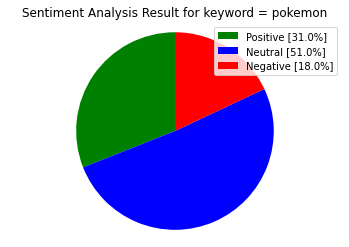

In [17]:
#assign to pie chart. instructions followed from: https://stackoverflow.com/questions/41088236/how-to-have-actual-values-in-matplotlib-pie-chart-displayed#:~:text=If%20you%27re%20looking%20to%20plot%20a%20piechart%20from,autopct%3D%20lambda%20x%3A%20%27%20%7B%3A.0f%7D%27.format%20%28x%2Avalues.sum%20%28%29%2F100%29%2C%20startangle%3D90%29
labels = ['Positive ['+str(pos_p)+'%]' , 'Neutral ['+str(neu_p)+'%]','Negative ['+str(neg_p)+'%]']
sizes = [pos_p, neu_p, neg_p]
colors = ['green','blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword = "+twitterAccount+"" )
plt.axis('equal')
plt.show()

In [18]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = df[df["Score"]=="negative"]
tw_list_positive = df[df["Score"]=="positive"]
tw_list_neutral = df[df["Score"]=="neutral"]

In [19]:
#Creating new dataframe and new features dor word cloud
tweet_list = []

for tweet in tweets:
    #print(tweet.text)
    tweet_list.append(tweet.Tweet)

tweet_list = pd.DataFrame(tweet_list)
tweet_list["text"] = df['Tweet']
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list.text.str.lower()

#Function to Create Wordcloud
def create_wordcloud(text): 
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    pa = wc.generate(str(text))
    print("Word Cloud Saved Successfully")
    plt.imshow(pa)
    plt.axis('off')
    plt.show()

Word Cloud Saved Successfully


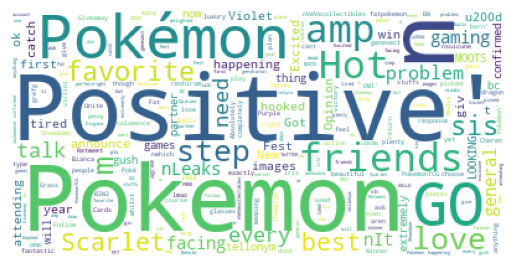

In [20]:
#Creating wordcloud for all tweets
create_wordcloud(positive.values)

Word Cloud Saved Successfully


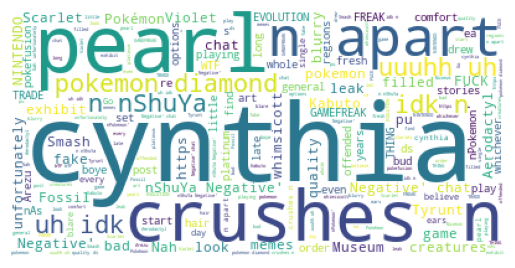

In [21]:
#Creating wordcloud for positive sentiment
create_wordcloud(negative.values)

Word Cloud Saved Successfully


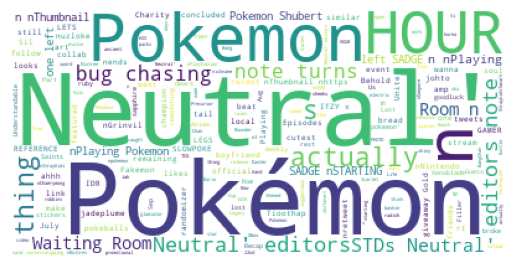

In [22]:
#Creating wordcloud for positive sentiment
create_wordcloud(neutral.values)